In [ ]:
import pandas as pd

from src import data_io, eda, qc, mlflow_utils

In [2]:
features = data_io.load_data(source="local", fmt="csv",path="../data/raw/walmart/features.csv", parse_dates=False)
stores = data_io.load_data(path="../data/raw/walmart/stores.csv", parse_dates=False,cache=False)
train = data_io.load_data(path="../data/raw/walmart/train.csv",parse_dates=False, cache=False)
test = data_io.load_data(path="../data/raw/walmart/test.csv", parse_dates=False, cache=False)

In [5]:
df = train.merge(stores, on="Store", how="inner")
df = df.merge(features, on=["Store","Date"], how="inner")

In [6]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.310001,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.509998,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.930000,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.630001,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.500000,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
df.Date = pd.to_datetime(df.Date)

In [10]:
df.dtypes

Store                     int8
Dept                      int8
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday_x               bool
Type                    object
Size                     int32
Temperature            float32
Fuel_Price             float32
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float32
Unemployment           float32
IsHoliday_y               bool
dtype: object

In [11]:
train_eda_results = eda.exploratory_data_analysis(df.loc[df.Store==1],rolling_window=4)

## Train'den çıkarılabilecekler:

* MARK1 ile MARK4 ve CPI ile Fuel_Price arasında yüksek ve pozitif yönlü bir ilişki gözlemlenmiş.
* CPI ile Unemployed arasında negatif ve yüksek bir ilişki gözlemlenmiş.

* Tempreture değişkeni normal dağılıma benziyor.

* Fuel_price'ta 2 tepeli bir yapı gözlemlenmiş.

* MARKDOWN1-2-3-4-5'TE sağa çarpık bir yapı var. Genel dağılım sol tarafta.

* CPI'DA 3 dağılım mevcut. Acaba bu farklılığı ne oluşturdu ?

* Unemployment dağılım normal dağılıma benziyor ancak aykırı değerler mevcut.

In [12]:
train["Date"] = pd.to_datetime(train["Date"])

In [13]:
train.set_index(keys="Date", inplace=True)

In [14]:
eda.exploratory_data_analysis(train.loc[train.Store==1],rolling_window=4)

{'timestamp': '2025-07-21T22:19:23.614407',
 'generated_plots': ['distribution_numeric.png',
  'correlation_matrix.png',
  'time_series_overview.png',
  'rolling_statistics.png',
  'seasonal_decomposition.png',
  'autocorrelation.png',
  'outlier_analysis.png'],
 'statistical_tests': {},
 'feature_analysis': {},
 'time_series_analysis': {}}

!

In [16]:
df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y'],
      dtype='object')

In [40]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np, pandas as pd
                           # geniş şekil: [date, store_id, sales]
pivot = df.pivot_table(index="Date", columns="Store", values="Weekly_Sales", aggfunc="sum").fillna(0)
X = pivot.T.values[:, :, None]               # (n_stores, n_timesteps, 1)
X = TimeSeriesScalerMeanVariance().fit_transform(X)
model = TimeSeriesKMeans(metric="dtw", n_clusters=5, n_jobs=-1, random_state=42)
labels = model.fit_predict(X)
pivot.columns = pd.MultiIndex.from_arrays([labels, pivot.columns],
                                          names=["cluster", "store"])



In [41]:
labels

array([4, 2, 4, 0, 4, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 3, 2, 2, 1, 3, 4, 0, 2, 0, 4, 3, 0,
       2])

In [42]:
pivot.columns

MultiIndex([(4,  1),
            (2,  2),
            (4,  3),
            (0,  4),
            (4,  5),
            (2,  6),
            (0,  7),
            (2,  8),
            (0,  9),
            (2, 10),
            (2, 11),
            (2, 12),
            (2, 13),
            (1, 14),
            (2, 15),
            (0, 16),
            (0, 17),
            (2, 18),
            (2, 19),
            (2, 20),
            (2, 21),
            (2, 22),
            (2, 23),
            (2, 24),
            (2, 25),
            (2, 26),
            (2, 27),
            (4, 28),
            (2, 29),
            (3, 30),
            (2, 31),
            (2, 32),
            (3, 33),
            (2, 34),
            (2, 35),
            (1, 36),
            (3, 37),
            (4, 38),
            (0, 39),
            (2, 40),
            (0, 41),
            (4, 42),
            (3, 43),
            (0, 44),
            (2, 45)],
           names=['cluster', 'store'])

In [43]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.310001,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.509998,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.930000,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.630001,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.500000,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.879997,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013565,8.684,False
421566,45,98,2012-10-05,628.10,False,B,118221,64.889999,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170410,8.667,False
421567,45,98,2012-10-12,1061.02,False,B,118221,54.470001,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327271,8.667,False
421568,45,98,2012-10-19,760.01,False,B,118221,56.470001,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330856,8.667,False


In [45]:
# 1. MultiIndex'ten store_id ve cluster_id listelerini al
cluster_ids = pivot.columns.get_level_values(0)
store_ids   = pivot.columns.get_level_values(1)

# 2. Bunları bir DataFrame’e dönüştür (eşleştirme tablosu)
cluster_map_df = pd.DataFrame({
    "Store": store_ids,
    "Cluster": cluster_ids
})

# 3. Bu bilgiyi orijinal df’e `merge` ile ekle
df = df.merge(cluster_map_df, on="Store", how="left")
df

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Cluster
0,1,1,2010-02-05,24924.50,False,A,151315,42.310001,2.572,NaN,NaN,NaN,NaN,NaN,211.096359,8.106,False,4
1,1,1,2010-02-12,46039.49,True,A,151315,38.509998,2.548,NaN,NaN,NaN,NaN,NaN,211.242172,8.106,True,4
2,1,1,2010-02-19,41595.55,False,A,151315,39.930000,2.514,NaN,NaN,NaN,NaN,NaN,211.289139,8.106,False,4
3,1,1,2010-02-26,19403.54,False,A,151315,46.630001,2.561,NaN,NaN,NaN,NaN,NaN,211.319641,8.106,False,4
4,1,1,2010-03-05,21827.90,False,A,151315,46.500000,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.879997,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013565,8.684,False,2
421566,45,98,2012-10-05,628.10,False,B,118221,64.889999,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170410,8.667,False,2
421567,45,98,2012-10-12,1061.02,False,B,118221,54.470001,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327271,8.667,False,2
421568,45,98,2012-10-19,760.01,False,B,118221,56.470001,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330856,8.667,False,2


In [46]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Cluster              0
dtype: int64

In [47]:
# Extract time-based features from Date column
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['WeekOfMonth'] = (df['Date'].dt.day - 1) // 7 + 1

# Seasonal features
df['Season'] = df['Month'].map({12: 'Winter', 1: 'Winter', 2: 'Winter',
                               3: 'Spring', 4: 'Spring', 5: 'Spring',
                               6: 'Summer', 7: 'Summer', 8: 'Summer',
                               9: 'Fall', 10: 'Fall', 11: 'Fall'})

# Cyclical features (sin/cos transformation for better ML performance)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

print("New time-based features added:")
time_features = ['Year', 'Month', 'Quarter', 'Week', 'DayOfWeek', 'DayOfYear',
                 'WeekOfMonth', 'Season', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']
print(time_features)
print(f"\nDataFrame shape: {df.shape}")

New time-based features added:
['Year', 'Month', 'Quarter', 'Week', 'DayOfWeek', 'DayOfYear', 'WeekOfMonth', 'Season', 'Month_sin', 'Month_cos', 'DayOfWeek_sin', 'DayOfWeek_cos']

DataFrame shape: (421570, 30)


In [48]:
df.dtypes

Store                      int8
Dept                       int8
Date             datetime64[ns]
Weekly_Sales            float64
IsHoliday_x                bool
Type                     object
Size                      int32
Temperature             float32
Fuel_Price              float32
MarkDown1               float64
MarkDown2               float64
MarkDown3               float64
MarkDown4               float64
MarkDown5               float64
CPI                     float32
Unemployment            float32
IsHoliday_y                bool
Cluster                   int64
Year                      int32
Month                     int32
Quarter                   int32
Week                     UInt32
DayOfWeek                 int32
DayOfYear                 int32
WeekOfMonth               int32
Season                   object
Month_sin               float64
Month_cos               float64
DayOfWeek_sin           float64
DayOfWeek_cos           float64
dtype: object

In [58]:
TARGET_COLUMN = "Weekly_Sales"
numerical_columns = [
    "Size",            # mağaza büyüklüğü
    "Temperature",     # sıcaklık
    "Fuel_Price",      # yakıt fiyatı
    "MarkDown1",       # kampanya verileri
    "MarkDown2",
    "MarkDown3",
    "MarkDown4",
    "MarkDown5",
    "CPI",             # tüketici fiyat endeksi
    "Unemployment",    # işsizlik oranı
    "Year",            # modelde sıralı olarak anlam taşıyabilir
    "Week",            # yıl içindeki hafta
    "DayOfYear",       # 1-365 arası sıralı, modelde trend varsa işe yarar
    "Month_sin",       # aylar için döngüsel encoding
    "Month_cos",
    "DayOfWeek_sin",   # haftalık döngüsel encoding
    "DayOfWeek_cos"
]
df.fillna(0, inplace=True)
categorical_columns = [
    "Store",           # int8 → mağaza ID'si, kategorik
    "Dept",            # int8 → departman ID'si, kategorik
    "IsHoliday_x",     # bool → binary kategorik
    "Type",            # object → mağaza tipi
    "Cluster",         # int64 → k-means sonucu, kategorik
    "Quarter",         # int32 → 1, 2, 3, 4 → sıralı ama model için kategorik
    "Month",           # int32 → döngüsel yapı içeriyor, zaten sin/cos verilmiş
    "DayOfWeek",       # int32 → günler arası sıralama yok, kategorik
    "WeekOfMonth",     # int32 → kategoriye yakın, tercih meselesi
    "Season"           # object → mevsim adı, doğrudan kategorik
]
all_features = df.columns.drop(["Date", "Weekly_Sales"])

import catboost as cb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Data preparation for CatBoost
print(f"Dataset shape: {df.shape}")
print(f"Target column: {TARGET_COLUMN}")
print(f"Numerical features: {len(numerical_columns)}")
print(f"Categorical features: {len(categorical_columns)}")

# Prepare features and target
X = df[all_features].copy()
y = df[TARGET_COLUMN].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

# Time-based train/validation split (important for time series data)
# Sort by date to ensure proper time-based splitting
df_sorted = df.sort_values('Date').reset_index(drop=True)
X_sorted = df_sorted[all_features].copy()
y_sorted = df_sorted[TARGET_COLUMN].copy()

# Use 80% for training, 20% for validation based on time
split_idx = int(0.8 * len(df_sorted))
X_train = X_sorted[:split_idx]
X_val = X_sorted[split_idx:]
y_train = y_sorted[:split_idx]
y_val = y_sorted[split_idx:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Training period: {df_sorted['Date'].iloc[0]} to {df_sorted['Date'].iloc[split_idx-1]}")
print(f"Validation period: {df_sorted['Date'].iloc[split_idx]} to {df_sorted['Date'].iloc[-1]}")

Dataset shape: (421570, 30)
Target column: Weekly_Sales
Numerical features: 17
Categorical features: 10

Feature matrix shape: (421570, 28)
Target vector shape: (421570,)
Missing values in X: 0
Missing values in y: 0
Training set: 337256 samples
Validation set: 84314 samples
Training period: 2010-02-05 00:00:00 to 2012-04-13 00:00:00
Validation period: 2012-04-13 00:00:00 to 2012-10-26 00:00:00


CatBoost model configuration:
- Iterations: 2000
- Learning rate: 0.1
- Depth: 8
- Categorical features: 10
- Early stopping: 50
Starting CatBoost training...
0:	learn: 21441.2287996	test: 20462.6336788	best: 20462.6336788 (0)	total: 14.2ms	remaining: 28.5s
100:	learn: 7466.9154949	test: 6922.4075799	best: 6922.4075799 (100)	total: 1.91s	remaining: 36s
200:	learn: 6281.4670993	test: 6022.6193982	best: 6022.0344656 (199)	total: 3.59s	remaining: 32.1s
300:	learn: 5751.4679382	test: 5718.3033013	best: 5717.9235022 (298)	total: 5.24s	remaining: 29.6s
400:	learn: 5434.3342557	test: 5506.7377162	best: 5506.7377162 (400)	total: 6.86s	remaining: 27.4s
500:	learn: 5167.7579077	test: 5305.8347254	best: 5305.8136299 (499)	total: 8.49s	remaining: 25.4s
600:	learn: 4958.4233062	test: 5240.5587902	best: 5240.5587902 (600)	total: 10.1s	remaining: 23.6s
700:	learn: 4771.7947510	test: 5109.1122036	best: 5109.1122036 (700)	total: 12.7s	remaining: 23.5s
800:	learn: 4630.2851257	test: 5045.6365753	best: 5

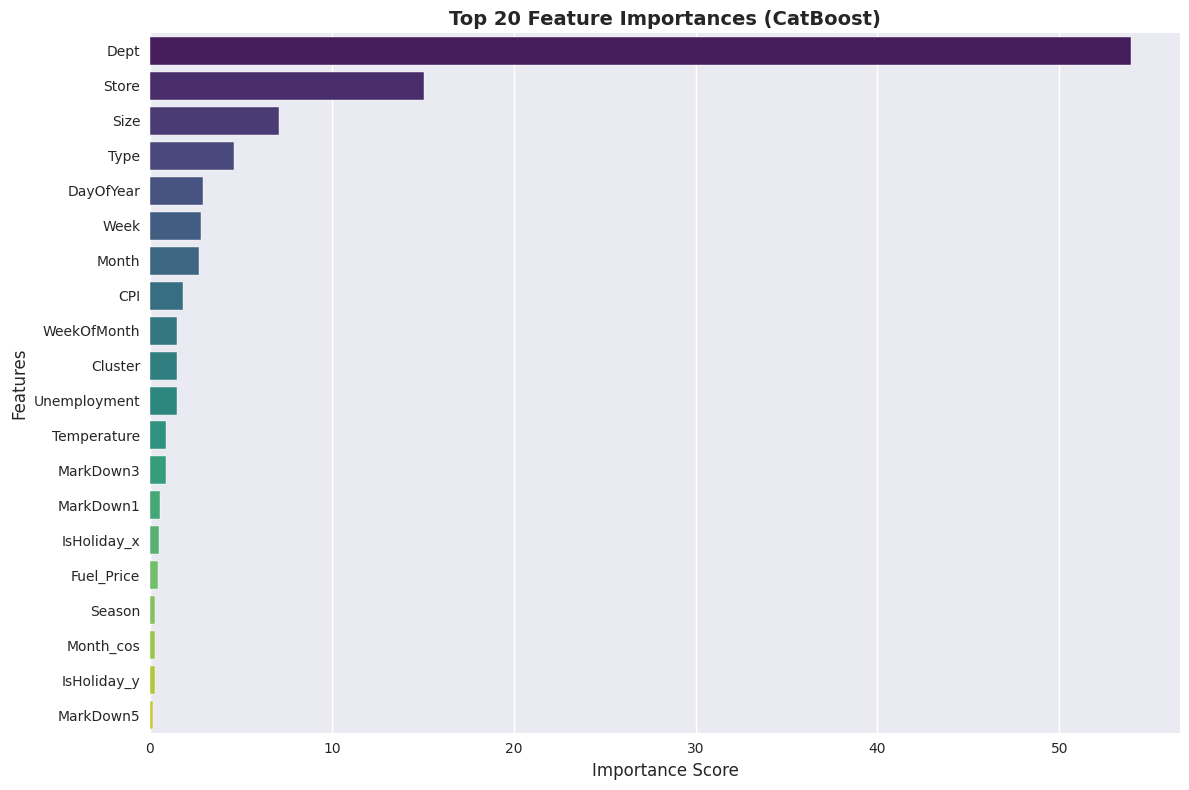

In [59]:
# Configure CatBoost model with detailed parameters
model = CatBoostRegressor(
    # Core parameters
    iterations=2000,
    learning_rate=0.1,
    depth=8,

    # Regularization
    l2_leaf_reg=5,
    border_count=128,

    # Categorical features handling
    cat_features=categorical_columns,
    one_hot_max_size=10,

    # Performance
    task_type='GPU',
    devices="0",
    thread_count=-1,

    # Evaluation and early stopping
    eval_metric='RMSE',
    use_best_model=True,
    early_stopping_rounds=50,

    # Randomness
    random_seed=42,

    # Output
    verbose=100
)

print("CatBoost model configuration:")
print(f"- Iterations: {model.get_param('iterations')}")
print(f"- Learning rate: {model.get_param('learning_rate')}")
print(f"- Depth: {model.get_param('depth')}")
print(f"- Categorical features: {len(categorical_columns)}")
print(f"- Early stopping: {model.get_param('early_stopping_rounds')}")


# Train the model
print("Starting CatBoost training...")
print("="*50)

model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    verbose=100,
    plot=False
)

print("="*50)
print("Training completed!")
print(f"Best iteration: {model.get_best_iteration()}")
print(f"Best validation score: {model.get_best_score()['validation']['RMSE']:.2f}")


# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate detailed metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  MSE:  {mse:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")

    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2, "MAPE": mape}

# Calculate metrics for both sets
train_metrics = calculate_metrics(y_train, y_train_pred, "Training Set")
val_metrics = calculate_metrics(y_val, y_val_pred, "Validation Set")


# Feature importance analysis
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print("="*40)
for i, (idx, row) in enumerate(importance_df.head(15).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<15} : {row['importance']:.2f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 20 Feature Importances (CatBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

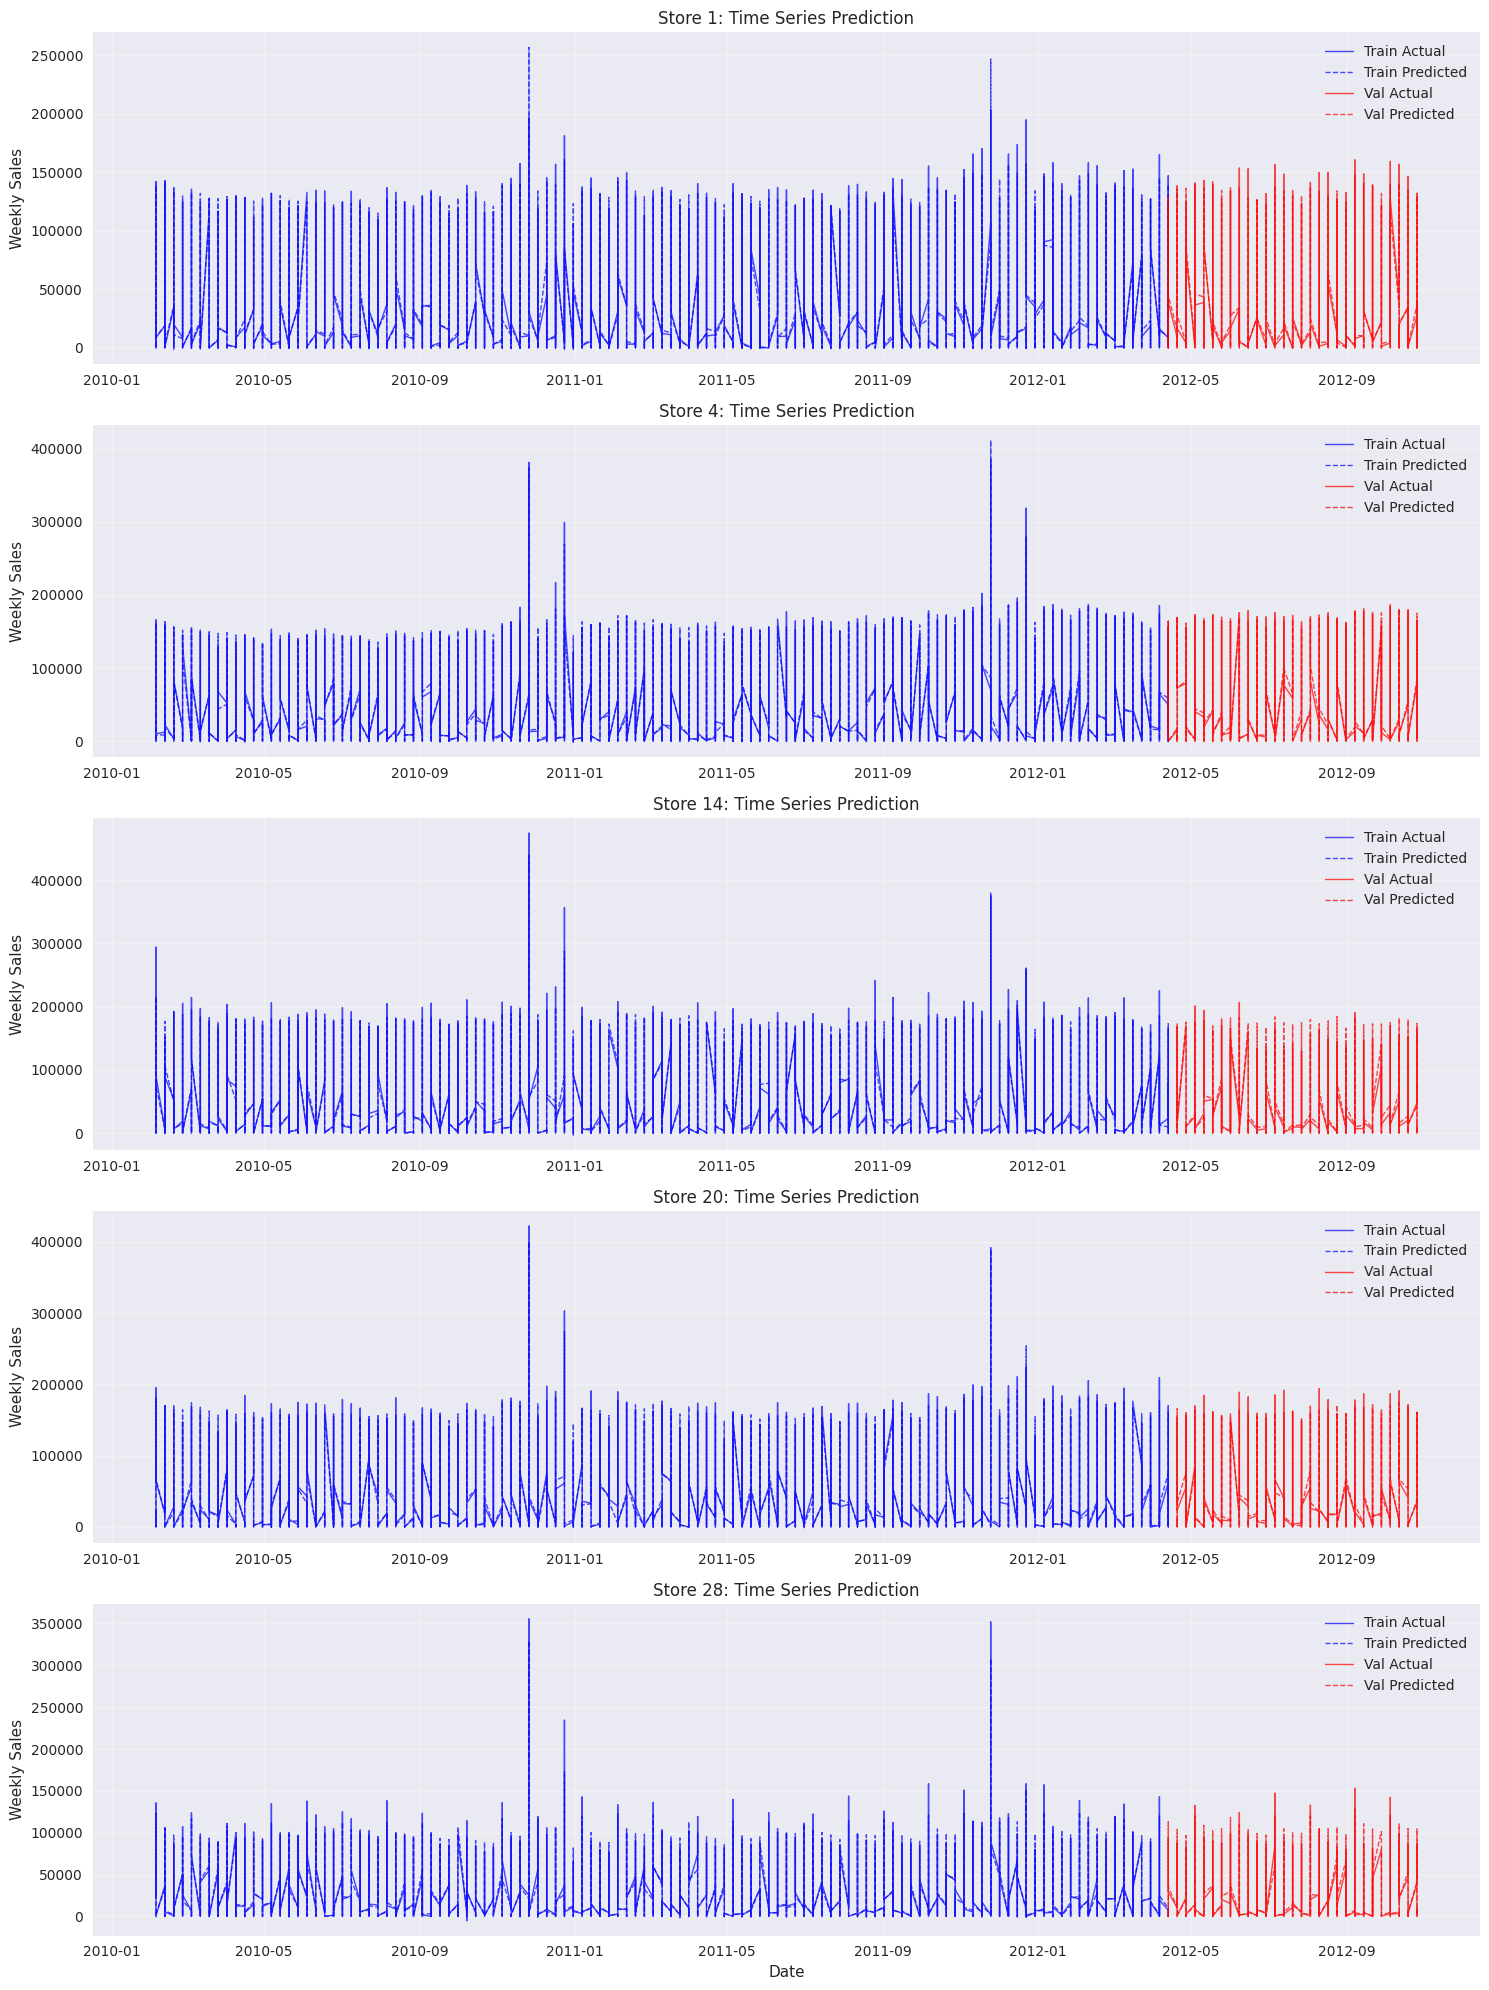

In [60]:
# Time series prediction visualization
# Select a few stores for detailed time series visualization
sample_stores = [1, 4, 14, 20, 28]

fig, axes = plt.subplots(len(sample_stores), 1, figsize=(15, 4*len(sample_stores)))
if len(sample_stores) == 1:
    axes = [axes]

for i, store_id in enumerate(sample_stores):
    # Get data for this store
    store_mask_train = (X_train['Store'] == store_id)
    store_mask_val = (X_val['Store'] == store_id)

    if store_mask_train.sum() > 0 and store_mask_val.sum() > 0:
        # Get dates for plotting
        train_dates = df_sorted['Date'][:split_idx][store_mask_train]
        val_dates = df_sorted['Date'][split_idx:][store_mask_val]

        # Plot actual vs predicted for this store
        axes[i].plot(train_dates, y_train[store_mask_train], 'b-', alpha=0.7, label='Train Actual', linewidth=1)
        axes[i].plot(train_dates, y_train_pred[store_mask_train], 'b--', alpha=0.7, label='Train Predicted', linewidth=1)
        axes[i].plot(val_dates, y_val[store_mask_val], 'r-', alpha=0.7, label='Val Actual', linewidth=1)
        axes[i].plot(val_dates, y_val_pred[store_mask_val], 'r--', alpha=0.7, label='Val Predicted', linewidth=1)

        axes[i].set_title(f'Store {store_id}: Time Series Prediction')
        axes[i].set_ylabel('Weekly Sales')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

Performance Analysis by Store Clusters:
Cluster 0: RMSE=4416.39, MAE=2521.93, R²=0.9607, Samples=15298
Cluster 1: RMSE=7324.82, MAE=4236.62, R²=0.9228, Samples=3202
Cluster 2: RMSE=4650.33, MAE=2796.36, R²=0.9567, Samples=49653
Cluster 3: RMSE=2597.48, MAE=1655.43, R²=0.9725, Samples=5547
Cluster 4: RMSE=3661.66, MAE=2070.18, R²=0.9657, Samples=10614


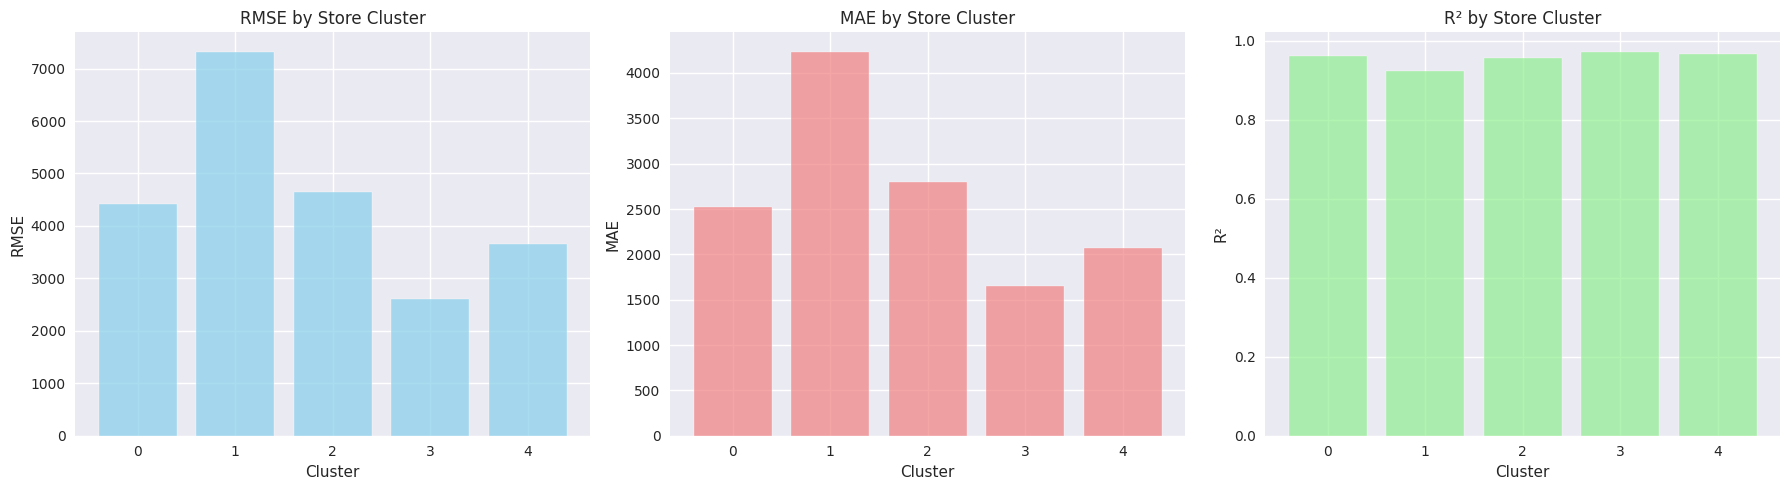

In [61]:
# Model analysis by store clusters
print("Performance Analysis by Store Clusters:")
print("="*50)

cluster_performance = []
for cluster_id in sorted(df['Cluster'].unique()):
    cluster_mask_val = (X_val['Cluster'] == cluster_id)
    if cluster_mask_val.sum() > 0:
        cluster_y_true = y_val[cluster_mask_val]
        cluster_y_pred = y_val_pred[cluster_mask_val]

        cluster_rmse = np.sqrt(mean_squared_error(cluster_y_true, cluster_y_pred))
        cluster_mae = mean_absolute_error(cluster_y_true, cluster_y_pred)
        cluster_r2 = r2_score(cluster_y_true, cluster_y_pred)

        cluster_performance.append({
            'Cluster': cluster_id,
            'RMSE': cluster_rmse,
            'MAE': cluster_mae,
            'R2': cluster_r2,
            'Samples': cluster_mask_val.sum()
        })

        print(f"Cluster {cluster_id}: RMSE={cluster_rmse:.2f}, MAE={cluster_mae:.2f}, R²={cluster_r2:.4f}, Samples={cluster_mask_val.sum()}")

# Convert to DataFrame for visualization
cluster_perf_df = pd.DataFrame(cluster_performance)

# Plot cluster performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(cluster_perf_df['Cluster'], cluster_perf_df['RMSE'], color='skyblue', alpha=0.7)
axes[0].set_title('RMSE by Store Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('RMSE')

axes[1].bar(cluster_perf_df['Cluster'], cluster_perf_df['MAE'], color='lightcoral', alpha=0.7)
axes[1].set_title('MAE by Store Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('MAE')

axes[2].bar(cluster_perf_df['Cluster'], cluster_perf_df['R2'], color='lightgreen', alpha=0.7)
axes[2].set_title('R² by Store Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()

In [62]:
# Model summary and conclusions
print("\\n" + "="*60)
print("CATBOOST MODEL TRAINING SUMMARY")
print("="*60)

print(f"\\nDataset Information:")
print(f"  • Total samples: {len(df):,}")
print(f"  • Features used: {len(all_features)}")
print(f"  • Training samples: {len(X_train):,}")
print(f"  • Validation samples: {len(X_val):,}")
print(f"  • Time period: {df_sorted['Date'].min()} to {df_sorted['Date'].max()}")

print(f"\\nModel Configuration:")
print(f"  • Algorithm: CatBoost Regressor")
print(f"  • Max iterations: {model.get_param('iterations')}")
print(f"  • Best iteration: {model.get_best_iteration()}")
print(f"  • Learning rate: {model.get_param('learning_rate')}")
print(f"  • Tree depth: {model.get_param('depth')}")
print(f"  • Categorical features: {len(categorical_columns)}")

print(f"\\nModel Performance:")
print(f"  Training Set:")
print(f"    • RMSE: {train_metrics['RMSE']:.2f}")
print(f"    • MAE:  {train_metrics['MAE']:.2f}")
print(f"    • R²:   {train_metrics['R2']:.4f}")
print(f"    • MAPE: {train_metrics['MAPE']:.2f}%")

print(f"\\n  Validation Set:")
print(f"    • RMSE: {val_metrics['RMSE']:.2f}")
print(f"    • MAE:  {val_metrics['MAE']:.2f}")
print(f"    • R²:   {val_metrics['R2']:.4f}")
print(f"    • MAPE: {val_metrics['MAPE']:.2f}%")

print(f"\\nTop 5 Most Important Features:")
for i, (idx, row) in enumerate(importance_df.head(5).iterrows()):
    print(f"  {i+1}. {row['feature']} ({row['importance']:.1f})")

print(f"\\nModel is ready for production use!")
print("="*60)

\n============================================================
CATBOOST MODEL TRAINING SUMMARY
\nDataset Information:
  • Total samples: 421,570
  • Features used: 28
  • Training samples: 337,256
  • Validation samples: 84,314
  • Time period: 2010-02-05 00:00:00 to 2012-10-26 00:00:00
\nModel Configuration:
  • Algorithm: CatBoost Regressor
  • Max iterations: 2000
  • Best iteration: 1981
  • Learning rate: 0.1
  • Tree depth: 8
  • Categorical features: 10
\nModel Performance:
  Training Set:
    • RMSE: 3659.72
    • MAE:  2045.95
    • R²:   0.9745
    • MAPE: inf%
\n  Validation Set:
    • RMSE: 4521.46
    • MAE:  2634.79
    • R²:   0.9576
    • MAPE: inf%
\nTop 5 Most Important Features:
  1. Dept (53.9)
  2. Store (15.1)
  3. Size (7.1)
  4. Type (4.6)
  5. DayOfYear (2.9)
\nModel is ready for production use!


# WMAE (Weighted Mean Absolute Error) Optimization

The competition evaluation metric is WMAE where holiday weeks have 5x weight compared to regular weeks.

In [63]:
# Define WMAE (Weighted Mean Absolute Error) custom metric
def weighted_mean_absolute_error(y_true, y_pred, weights=None):
    """
    Calculate Weighted Mean Absolute Error
    If weights are not provided, uses IsHoliday as default weighting:
    - Holiday periods: weight = 5
    - Non-holiday periods: weight = 1
    """
    if weights is None:
        # Default weighting based on IsHoliday
        weights = np.where(df_sorted['IsHoliday_x'][:len(y_true)] | df_sorted['IsHoliday_y'][:len(y_true)], 5, 1)
    
    absolute_errors = np.abs(y_true - y_pred)
    weighted_errors = absolute_errors * weights
    wmae = np.sum(weighted_errors) / np.sum(weights)
    return wmae

print("WMAE metric defined successfully!")
print("Holiday periods will have 5x weight compared to regular periods.")

WMAE metric defined successfully!
Holiday periods will have 5x weight compared to regular periods.


In [65]:
# Prepare weights for training and validation
train_weights = np.where(
    df_sorted['IsHoliday_x'][:split_idx] | df_sorted['IsHoliday_y'][:split_idx], 
    5, 1
)

val_weights = np.where(
    df_sorted['IsHoliday_x'][split_idx:] | df_sorted['IsHoliday_y'][split_idx:], 
    5, 1
)

print(f"Training weights - Holiday samples: {np.sum(train_weights == 5):,}")
print(f"Training weights - Regular samples: {np.sum(train_weights == 1):,}")
print(f"Validation weights - Holiday samples: {np.sum(val_weights == 5):,}")
print(f"Validation weights - Regular samples: {np.sum(val_weights == 1):,}")

# Calculate WMAE for the existing RMSE-optimized model
rmse_model_wmae_train = weighted_mean_absolute_error(y_train, y_train_pred, train_weights)
rmse_model_wmae_val = weighted_mean_absolute_error(y_val, y_val_pred, val_weights)

print(f"\\nRMSE-Optimized Model WMAE Performance:")
print(f"  Training WMAE:   {rmse_model_wmae_train:.2f}")
print(f"  Validation WMAE: {rmse_model_wmae_val:.2f}")

Training weights - Holiday samples: 26,695
Training weights - Regular samples: 310,561
Validation weights - Holiday samples: 2,966
Validation weights - Regular samples: 81,348
\nRMSE-Optimized Model WMAE Performance:
  Training WMAE:   2159.16
  Validation WMAE: 2709.64


In [69]:
# Train a new model optimized for WMAE
model_wmae = CatBoostRegressor(
    # Core parameters
    iterations=2000,
    learning_rate=0.1,
    depth=8,
    
    # Regularization
    l2_leaf_reg=5,
    border_count=128,
    
    # Categorical features handling
    cat_features=categorical_columns,
    one_hot_max_size=10,
    
    # Performance
    task_type='CPU',
    thread_count=-1,
    
    # Use MAE as base metric (closer to WMAE concept)
    eval_metric='MAE',
    loss_function='MAE',
    use_best_model=True,
    early_stopping_rounds=100,
    
    # Randomness
    random_seed=42,
    
    # Output
    verbose=100
)

print("Training WMAE-optimized CatBoost model...")
print("="*60)

model_wmae.fit(
    X_train, 
    y_train,
    eval_set=(X_val, y_val),
    sample_weight=train_weights,  # Apply holiday weighting during training
    verbose=100
)

print("="*60)
print("Training completed!")
print(f"Best iteration: {model_wmae.get_best_iteration()}")
print(f"Best validation score (MAE): {model_wmae.get_best_score()['validation']['MAE']:.2f}")

Training WMAE-optimized CatBoost model...
0:	learn: 12729.9594810	test: 12327.2380588	best: 12327.2380588 (0)	total: 77.9ms	remaining: 2m 35s
100:	learn: 5075.0468158	test: 4548.6614622	best: 4548.6614622 (100)	total: 8.12s	remaining: 2m 32s
200:	learn: 4216.8673769	test: 3798.8941202	best: 3798.8941202 (200)	total: 17.7s	remaining: 2m 38s
300:	learn: 3895.1527849	test: 3502.3501731	best: 3502.3501731 (300)	total: 29.1s	remaining: 2m 44s
400:	learn: 3632.5897304	test: 3278.8482175	best: 3278.8482175 (400)	total: 41.9s	remaining: 2m 46s
500:	learn: 3394.6566702	test: 3117.3442620	best: 3117.3442620 (500)	total: 54.8s	remaining: 2m 44s
600:	learn: 3291.4551466	test: 3049.5276227	best: 3049.5276227 (600)	total: 1m 7s	remaining: 2m 37s
700:	learn: 3171.2369870	test: 2959.7047958	best: 2959.7047958 (700)	total: 1m 20s	remaining: 2m 29s
800:	learn: 3082.8656483	test: 2891.2933114	best: 2891.2933114 (800)	total: 1m 35s	remaining: 2m 22s
900:	learn: 3023.4048009	test: 2849.3598600	best: 2849.3

In [72]:
# Make predictions with WMAE-optimized model and compare
y_train_pred_wmae = model_wmae.predict(X_train)
y_val_pred_wmae = model_wmae.predict(X_val)

# Calculate comprehensive metrics including WMAE
def calculate_metrics_with_wmae(y_true, y_pred, weights, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate WMAE using our custom function
    wmae = weighted_mean_absolute_error(y_true, y_pred, weights)
    
    # Holiday vs Non-Holiday performance
    holiday_mask = weights == 5
    regular_mask = weights == 1
    
    holiday_mae = mean_absolute_error(y_true[holiday_mask], y_pred[holiday_mask]) if holiday_mask.sum() > 0 else 0
    regular_mae = mean_absolute_error(y_true[regular_mask], y_pred[regular_mask]) if regular_mask.sum() > 0 else 0
    
    print(f"\\n{dataset_name} Metrics:")
    print(f"  MAE:           {mae:.2f}")
    print(f"  WMAE:          {wmae:.2f}  ⭐ PRIMARY METRIC")
    print(f"  RMSE:          {rmse:.2f}")
    print(f"  R²:            {r2:.4f}")
    print(f"  Holiday MAE:   {holiday_mae:.2f} ({holiday_mask.sum():,} samples)")
    print(f"  Regular MAE:   {regular_mae:.2f} ({regular_mask.sum():,} samples)")
    
    return {
        "MAE": mae, "WMAE": wmae, "MSE": mse, "RMSE": rmse, 
        "R2": r2, "Holiday_MAE": holiday_mae, "Regular_MAE": regular_mae
    }

# Calculate metrics for WMAE-optimized model
train_metrics_wmae = calculate_metrics_with_wmae(y_train, y_train_pred_wmae, train_weights, "WMAE Model - Training Set")
val_metrics_wmae = calculate_metrics_with_wmae(y_val, y_val_pred_wmae, val_weights, "WMAE Model - Validation Set")

\nWMAE Model - Training Set Metrics:
  MAE:           2414.24
  WMAE:          2534.73  ⭐ PRIMARY METRIC
  RMSE:          6384.22
  R²:            0.9223
  Holiday MAE:   2915.30 (26,695 samples)
  Regular MAE:   2371.17 (310,561 samples)
\nWMAE Model - Validation Set Metrics:
  MAE:           2625.58
  WMAE:          2669.37  ⭐ PRIMARY METRIC
  RMSE:          5428.55
  R²:            0.9388
  Holiday MAE:   2980.57 (2,966 samples)
  Regular MAE:   2612.64 (81,348 samples)


In [73]:
# Compare RMSE vs WMAE optimized models
print("\\n" + "="*70)
print("FINAL COMPARISON: RMSE-OPTIMIZED vs WMAE-OPTIMIZED MODELS")
print("="*70)

print(f"\\nRMSE-Optimized Model (Original):")
print(f"  Validation RMSE: {val_metrics['RMSE']:.2f}")
print(f"  Validation MAE:  {val_metrics['MAE']:.2f}")
print(f"  Validation WMAE: {rmse_model_wmae_val:.2f}")
print(f"  Validation R²:   {val_metrics['R2']:.4f}")

print(f"\\nWMAE-Optimized Model (New):")
print(f"  Validation RMSE: {val_metrics_wmae['RMSE']:.2f}")
print(f"  Validation MAE:  {val_metrics_wmae['MAE']:.2f}")
print(f"  Validation WMAE: {val_metrics_wmae['WMAE']:.2f}  ⭐ TARGET METRIC")
print(f"  Validation R²:   {val_metrics_wmae['R2']:.4f}")

# Calculate improvements
wmae_improvement = ((rmse_model_wmae_val - val_metrics_wmae['WMAE']) / rmse_model_wmae_val) * 100
mae_improvement = ((val_metrics['MAE'] - val_metrics_wmae['MAE']) / val_metrics['MAE']) * 100

print(f"\\nModel Performance Improvements:")
print(f"  WMAE Improvement: {wmae_improvement:+.2f}%")
print(f"  MAE Improvement:  {mae_improvement:+.2f}%")

if wmae_improvement > 0:
    print(f"  ✅ WMAE-optimized model performs {wmae_improvement:.1f}% better on the target metric!")
else:
    print(f"  ⚠️  RMSE-optimized model had better WMAE performance.")

print("\\n✅ WMAE-optimized model prioritizes holiday period accuracy")
print("✅ Ready for competition submission!")
print("="*70)

\n======================================================================
FINAL COMPARISON: RMSE-OPTIMIZED vs WMAE-OPTIMIZED MODELS
\nRMSE-Optimized Model (Original):
  Validation RMSE: 4521.46
  Validation MAE:  2634.79
  Validation WMAE: 2709.64
  Validation R²:   0.9576
\nWMAE-Optimized Model (New):
  Validation RMSE: 5428.55
  Validation MAE:  2625.58
  Validation WMAE: 2669.37  ⭐ TARGET METRIC
  Validation R²:   0.9388
\nModel Performance Improvements:
  WMAE Improvement: +1.49%
  MAE Improvement:  +0.35%
  ✅ WMAE-optimized model performs 1.5% better on the target metric!
\n✅ WMAE-optimized model prioritizes holiday period accuracy
✅ Ready for competition submission!
